In [11]:
from PIL import Image
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import h5py
from matplotlib import pyplot as plt
%matplotlib inline

# Import Images

In [12]:
#assumes image is larger than the resize
#resize useing shrink and center crop
def resize_scc(im,rs=[500,500]):
    s=im.size
    d = (s[0]-rs[0],s[1]-rs[1])
    md,r = min(d),np.argmin(d)

    if r == 1:
        p_dec = float((s[1]-md))/s[1]
    else:
        p_dec = float((s[0]-md))/s[0]

    im2 = im.resize([int(s[0]*p_dec),int(s[1]*p_dec)],resample=Image.BILINEAR)

    if r == 1:
        chop = int(float(im2.size[0]-rs[0])/2.0)
        im3 = im2.crop(box=[chop,0,chop+rs[0],rs[1]])
    else:
        chop = int(float(im2.size[1]-rs[1])/2.0)
        im3 = im2.crop(box=[0,chop,rs[0],chop+rs[1]])
    assert list(im3.size) == rs
    return im3



In [13]:
rs = [400,320]

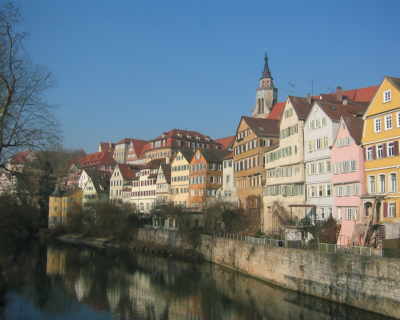

In [14]:
im = Image.open('Tuebingen_Neckarfront.jpg')
# im2 = im.resize([224,224])
im = resize_scc(im,rs=rs)
content = np.array(im,dtype=np.float32).reshape((im.size[1],im.size[0],3))
#im.size
im

In [15]:
im.size

(400, 320)

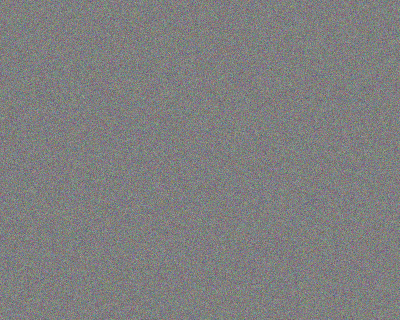

In [16]:
wn = np.clip((np.random.randn(im.size[1],im.size[0],3)*np.sqrt(255.0))+255.0/2,0,255)
Image.fromarray(np.uint8(wn.reshape(im.size[1],im.size[0],3)))

In [17]:
wn.shape

(320, 400, 3)

# PreProcess Images

In [18]:
def pre_process(x):
    x=x[:,:,::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x
def post_process(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x=x[:,:,::-1]
    return x

In [19]:
content = pre_process(content)
wn = pre_process(wn)

content=np.expand_dims(content,axis=0)
wn=np.expand_dims(wn,axis=0)

In [20]:
g = tf.Graph()
with g.as_default():
    content_img = tf.constant(content,dtype=tf.float32)
    alter_img = tf.Variable(initial_value=wn,dtype=tf.float32)
    

# Build VGG19

## Extract weights

In [21]:
f = h5py.File("vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [22]:
for l in f.keys():
    print l

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
input_2


In [23]:
def parse_layer_conv(x):
    if 'conv' in x:
        c = x.split('conv')[-1]
        b = x.split('block')[1].split('_')[0]
        return (c,b)
    else:
        return None

In [24]:
# x = '1_1'
def getName(x):
    b,c = x.split('_')
    return 'block'+b+'_conv'+c

In [25]:
getName('1_1')

'block1_conv1'

In [26]:
def getW(f,l):
    return f[l].values()[0].value
def getb(f,l):
    return f[l].values()[1].value

## Add Graph

In [27]:

with g.as_default():
    def vgg19(img):
        # Set up weights as constants
        #Block 1
        w1_1 = tf.constant(getW(f,getName('1_1')))
        b1_1 = tf.constant(getb(f,getName('1_1')))
        w1_2 = tf.constant(getW(f,getName('1_2')))
        b1_2 = tf.constant(getb(f,getName('1_2')))

        #Block 2
        w2_1 = tf.constant(getW(f,getName('2_1')))
        b2_1 = tf.constant(getb(f,getName('2_1')))
        w2_2 = tf.constant(getW(f,getName('2_2')))
        b2_2 = tf.constant(getb(f,getName('2_2')))
        
        #Block 3
        w3_1 = tf.constant(getW(f,getName('3_1')))
        b3_1 = tf.constant(getb(f,getName('3_1')))
        w3_2 = tf.constant(getW(f,getName('3_2')))
        b3_2 = tf.constant(getb(f,getName('3_2')))
        w3_3 = tf.constant(getW(f,getName('3_3')))
        b3_3 = tf.constant(getb(f,getName('3_3')))
        
        #Block 4
        w4_1 = tf.constant(getW(f,getName('4_1')))
        b4_1 = tf.constant(getb(f,getName('4_1')))
        w4_2 = tf.constant(getW(f,getName('4_2')))
        b4_2 = tf.constant(getb(f,getName('4_2')))
        w4_3 = tf.constant(getW(f,getName('4_3')))
        b4_3 = tf.constant(getb(f,getName('4_3')))
        
        #Block 4
        w5_1 = tf.constant(getW(f,getName('5_1')))
        b5_1 = tf.constant(getb(f,getName('5_1')))
        w5_2 = tf.constant(getW(f,getName('5_2')))
        b5_2 = tf.constant(getb(f,getName('5_2')))
        w5_3 = tf.constant(getW(f,getName('5_3')))
        b5_3 = tf.constant(getb(f,getName('5_3')))

        #Add convolution operations
        #Block 1
        conv1_1 = tf.nn.relu(tf.nn.conv2d(img,w1_1,[1,1,1,1],padding='SAME')+b1_1)
        conv1_2 = tf.nn.relu(tf.nn.conv2d(conv1_1,w1_2,[1,1,1,1],padding='SAME')+b1_2)
        pool1 = tf.nn.avg_pool(conv1_2,[1,3,3,1],[1,1,1,1],padding='SAME')

        #Block 2 = 
        conv2_1 = tf.nn.relu(tf.nn.conv2d(pool1,w2_1,[1,1,1,1],padding='SAME')+b2_1)
        conv2_2 = tf.nn.relu(tf.nn.conv2d(conv2_1,w2_2,[1,1,1,1],padding='SAME')+b2_2)
        pool2 = tf.nn.avg_pool(conv2_2,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        #Block 3
        conv3_1 = tf.nn.relu(tf.nn.conv2d(pool2,w3_1,[1,1,1,1],padding='SAME')+b3_1)
        conv3_2 = tf.nn.relu(tf.nn.conv2d(conv3_1,w3_2,[1,1,1,1],padding='SAME')+b3_2)
        conv3_3 = tf.nn.relu(tf.nn.conv2d(conv3_2,w3_3,[1,1,1,1],padding='SAME')+b3_3)
        pool3 = tf.nn.avg_pool(conv3_3,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        #Block 4
        conv4_1 = tf.nn.relu(tf.nn.conv2d(pool3,w4_1,[1,1,1,1],padding='SAME')+b4_1)
        conv4_2 = tf.nn.relu(tf.nn.conv2d(conv4_1,w4_2,[1,1,1,1],padding='SAME')+b4_2)
        conv4_3 = tf.nn.relu(tf.nn.conv2d(conv4_2,w4_3,[1,1,1,1],padding='SAME')+b4_3)
        pool4 = tf.nn.avg_pool(conv4_3,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        #Block 4
        conv5_1 = tf.nn.relu(tf.nn.conv2d(pool4,w5_1,[1,1,1,1],padding='SAME')+b5_1)
        conv5_2 = tf.nn.relu(tf.nn.conv2d(conv5_1,w5_2,[1,1,1,1],padding='SAME')+b5_2)
        conv5_3 = tf.nn.relu(tf.nn.conv2d(conv5_2,w5_3,[1,1,1,1],padding='SAME')+b5_3)
        pool5 = tf.nn.avg_pool(conv5_3,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        return [conv1_1,conv2_1,conv3_1,conv4_1,conv5_1,conv4_2]

# Train

Compute layers, set up losses, and backprop

In [28]:
alpha = 1.0
beta = 0.00001

In [57]:
with g.as_default():
    l_target,l_alter = vgg19(content_img),vgg19(alter_img)
    
    #Content
    l_target1,l_alter1 = l_target[0],l_alter[0]
    l_target2,l_alter2 = l_target[1],l_alter[1]
    l_target3,l_alter3 = l_target[2],l_alter[2]
    l_target4,l_alter4 = l_target[3],l_alter[3]
    l_target5,l_alter5 = l_target[4],l_alter[4]
    
    loss1 = 0.5*tf.reduce_sum(tf.square(l_target1-l_alter1))
    loss2 = 0.5*tf.reduce_sum(tf.square(l_target2-l_alter2))
    loss3 = 0.5*tf.reduce_sum(tf.square(l_target3-l_alter3))
    loss4 = 0.5*tf.reduce_sum(tf.square(l_target4-l_alter4))
    loss5 = 0.5*tf.reduce_sum(tf.square(l_target5-l_alter5))
    loss_content = loss3 
    
    opt = tf.train.AdamOptimizer(learning_rate=.5e0,beta1=.9,beta2=.999,epsilon=1e-08).minimize(loss_content)
    
    init = tf.global_variables_initializer()

In [58]:
sess = tf.Session(graph=g)
sess.run(init)
losses=[]

In [ ]:
num_steps = 1000
for i in tqdm(range(num_steps)):
    l,_=sess.run([loss_content,opt])
    losses.append(l)
    if i %10 == 0:
        after = sess.run(alter_img)
        after = post_process(after[0])
        Image.fromarray(np.uint8(np.clip(after,0,255))).save('Content3/img'+str(i/10)+'.png')
after = sess.run(alter_img)

 38%|███▊      | 383/1000 [01:32<02:24,  4.28it/s]

# Postprocess image

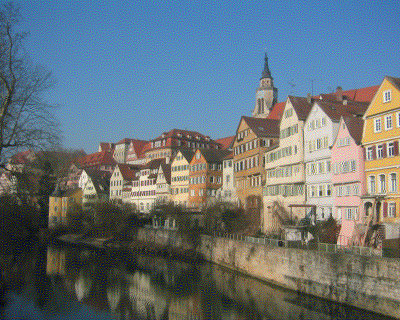

In [55]:
after = post_process(after[0])
Image.fromarray(np.uint8(np.clip(after,0,255)))

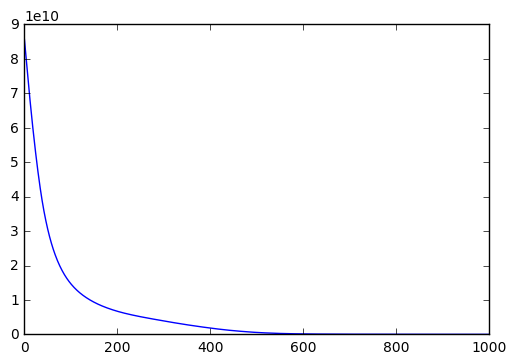

In [56]:
plt.plot(losses)